<h1> Homework 2 - Data from the Web </h1>

In [505]:
## Importation of everything useful
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import glob
import scipy
sns.set_context('notebook')

import requests
from bs4 import BeautifulSoup

<h1>Getting the data</h1>

In this first part we will concentrate on getting the datas. We used "Postman" to examine the different isa.epfl.ch pages. To get the data, we need to run an url with the right parameters. These parameters are the different fields of the form that we are going to get right in this part.

So here, we will use "Requests" and "BeautifulSoup" to get these parameters:

In [506]:
parameters_page = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247')
parameters_html = parameters_page.text
soup = BeautifulSoup(parameters_html, "html.parser")

We iterate on the page and look for the "select" tags which mean the beginning of a form field. In each of these form field, we find the different "option" that is available and store it in a dictionnary with the different important information.<br>
The list of dictionnary constructed will allow to create a dataframe with these information.

In [507]:
row_list = []
for parameter_cat_html in soup.find_all('select'):
    for option in parameter_cat_html.contents:
        row_dict = {'category':parameter_cat_html['name'], 'name':option.string, 'value':option['value']}
        row_list.append(row_dict)
parameters = pd.DataFrame(row_list)
parameters.head()

,category,name,value
0,ww_x_UNITE_ACAD,None,null
1,ww_x_UNITE_ACAD,Architecture,942293
2,ww_x_UNITE_ACAD,Chimie et génie chimique,246696
3,ww_x_UNITE_ACAD,Cours de mathématiques spéciales,943282
4,ww_x_UNITE_ACAD,EME (EPFL Middle East),637841336


<h2>Creating the base url</h2>

We found with Postman the base url leading to the students list: http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.bhtml

To this page, we will add different parameters. Some of the parameters will not change for all the request, therefore we decided to hardcode them. These parameters are:
<ul>
<li>
<b>ww_x_GPS</b> = <em>-1</em><br>
This parameter varies during request but is not useful. It is probably linked to the gps position. It is was set to -1 which will accept everything.
</li>
<li>
<b>ww_i_reportModel</b> = <em>133685247</em>:<br>
Parameter to choose the type of files to take. We chose html files.
</li>
<li><b>ww_i_reportModelXsl</b> = <em>133685270</em>:<br>
Parameter to choose the type of files to take. We chose html files.
</li>
<li><b>ww_x_HIVERETE</b> = <em>null</em>:<br>
This parameter allow to choose between Winter and Spring semester. However, it is redondant, as Bachelor 1 can only happen in Winter semester, Bachelor 2 in Spring, Bachelor 3 in Winter, and so forth. Therefore we chose to eliminate this parameter by settings its value to null.
</li>
</ul>

In [508]:
people_base_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.bhtml?ww_x_GPS=-1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_HIVERETE=null'

***Informatique parameter***<br>
We get the "informatique" category name and value in the parameters dataframe, as we are only going to consider this section.

In [509]:
## Function to create a small part of a url for a url parameter and its corresponding value. 
def url_param_str(param, value):
    return '&' + param + '=' + value

## Getting "informatique" row
informatique_param = parameters.loc[parameters['name'] == 'Informatique']

## Making informatique url
informatique_url_string = url_param_str(informatique_param.category.iloc[0], informatique_param.value.iloc[0])

##Adding url to the base url
people_base_url = people_base_url + informatique_url_string

***Parameters that vary***<br>
Therefore we are left with two interesting parameters we want to vary: the year ("periode academique") and the period ("periode pedagogique").

Here we get these parameters and drop the null value and the "Mise a niveau" which is not useful.

In [510]:
year_param_string = 'ww_x_PERIODE_ACAD'
period_param_string = 'ww_x_PERIODE_PEDAGO'

year_param = parameters.loc[parameters['category'] == year_param_string]
period_param = parameters.loc[parameters['category'] == period_param_string]

year_param = year_param.drop(year_param.iloc[0].name,axis=0, level=None)
period_param = period_param.drop(period_param.iloc[0].name,axis=0, level=None)
period_param = period_param[period_param['name'] != 'Mise à niveau']

In [511]:
year_param.head()

,category,name,value
21,ww_x_PERIODE_ACAD,2016-2017,355925344
22,ww_x_PERIODE_ACAD,2015-2016,213638028
23,ww_x_PERIODE_ACAD,2014-2015,213637922
24,ww_x_PERIODE_ACAD,2013-2014,213637754
25,ww_x_PERIODE_ACAD,2012-2013,123456101


In [512]:
period_param.head()

,category,name,value
32,ww_x_PERIODE_PEDAGO,Bachelor semestre 1,249108
33,ww_x_PERIODE_PEDAGO,Bachelor semestre 2,249114
34,ww_x_PERIODE_PEDAGO,Bachelor semestre 3,942155
35,ww_x_PERIODE_PEDAGO,Bachelor semestre 4,942163
36,ww_x_PERIODE_PEDAGO,Bachelor semestre 5,942120


*** Helper functions to make the dataframe: ***

In [513]:
## Take a dataframe of raw data just downloaded from isa and clean the data
def pretify_df(data_frame):
    # We change the name of the columns by the value of the second line of each columns\n",
    for i in range(0, len(data_frame.columns)):
        data_frame=data_frame.rename(columns = {i:data_frame.loc[1][i]})
        
    # We add a column for the period\n",
    string = data_frame['Civilité'][0]
    splitedString = string.split(',')
    
    data_frame['Period Academic'] = splitedString[1]
    periodPedagogic = splitedString[2].split(' ')[1:4]
    data_frame['Period pedagogic'] = ' '.join(periodPedagogic)
 
    # We drop the unuseful rows\n",
    # And we drop the columns that contains only NaN\n",
    data_frame = data_frame.drop(data_frame.index[[0,1]]).dropna(axis=1, how='all')
    return data_frame

In [514]:
## Create a dataframe from a url with an html tale
def create_df(url):
    # pd.read returns a list of dataframe
    # in our case, it returns a list of one dataframe,\n",
    # so we select the first item of this list\n",
    return pretify_df(pd.read_html(url)[0])

<h2>Downloading the data</h2><br>
Here we iterate over the year and period parameters, create the right url and get the datas. We use the helper functions to make dataframe and store the dataframe on files so we don't need to download them everytime.<br>
Some url throw an exception (that we catch) when there is no student in the file.

In [515]:
for i, year in year_param.iterrows():
    for j, period in period_param.iterrows():
        
        url_i = people_base_url + url_param_str(year.category, year.value) + url_param_str(period.category, period.value)
        file_name_i = './data/' + str(year['name']+period['name'])
        print(file_name_i)
        try:
            df_i = create_df(url_i)
        except (ValueError, KeyError):
            print('-------> no file here!')
        else:
            df_i.to_pickle(file_name_i)


./data/2016-2017Bachelor semestre 1
./data/2016-2017Bachelor semestre 2
./data/2016-2017Bachelor semestre 3
./data/2016-2017Bachelor semestre 4
./data/2016-2017Bachelor semestre 5
./data/2016-2017Bachelor semestre 5b
-------> no file here!
./data/2016-2017Bachelor semestre 6
./data/2016-2017Bachelor semestre 6b
-------> no file here!
./data/2016-2017Master semestre 1
./data/2016-2017Master semestre 2
./data/2016-2017Master semestre 3
./data/2016-2017Master semestre 4
-------> no file here!
./data/2016-2017Mineur semestre 1
-------> no file here!
./data/2016-2017Mineur semestre 2
-------> no file here!
./data/2016-2017Projet Master automne
./data/2016-2017Projet Master printemps
-------> no file here!
./data/2016-2017Semestre automne
./data/2016-2017Semestre printemps
./data/2016-2017Stage automne 3ème année
-------> no file here!
./data/2016-2017Stage automne 4ème année
-------> no file here!
./data/2016-2017Stage printemps 3ème année
-------> no file here!
./data/2016-2017Stage printe

## Exercise 1
We import the data stored, and create a list of dataframes for Bachelor 1 and Bachelor 6

In [516]:
bachelors_sem1 = glob.glob('.\\data\\[0-9]*-[0-9]*Bachelor semestre 1')
bachelors_sem6 = glob.glob('.\\data\\[0-9]*-[0-9]*Bachelor semestre 6')

sem1_dfs = [pd.read_pickle(data_file) for data_file in bachelors_sem1]
sem6_dfs = [pd.read_pickle(data_file) for data_file in bachelors_sem6]

In [517]:
sem1_dfs[4].head(1)

,Civilité,Nom Prénom,Statut,No Sciper,Period Academic,Period pedagogic
2,Monsieur,Aiulfi Loris Sandro,Présent,202293,2011-2012,Bachelor semestre 1


We change the academic year according to the fact that the first semester of bachelor start during the first year provided, and the last for Bachelor 6

Ex: for 2012-2013 for Bachelor 1, the correcting_year function will changed it to 2012 and
    for 2014-2015 for Bachelor 6, the correcting_year function will changed it to 2015

In [518]:
def correcting_year(listOne, listSix):
    #For all Bachelor 1, we select the firt year of the column Period Academic
    for df in listOne:
        df["Period Academic"]=int(df['Period Academic'][2].split('-')[0].replace(" ", ""))

    #For all Bachelor 6, we select the second year of the column Period Academic
    for df in listSix:
        df["Period Academic"] = int(df['Period Academic'][2].split('-')[1])   

In [519]:
correcting_year(sem1_dfs, sem6_dfs)

In [520]:
sem1_dfs[4].head(1)

,Civilité,Nom Prénom,Statut,No Sciper,Period Academic,Period pedagogic
2,Monsieur,Aiulfi Loris Sandro,Présent,202293,2011,Bachelor semestre 1


We fisrt concatenate all the dataframes for each semester in a big dataframe
then, we sort them by ascending Period Academic
and finally, for Bachelor 1, we drop duplicate and keep the first entry,
and for Bachelor 6, we drop duplicate and keep the last entry

In [521]:

bachelors_sem1 = pd.concat(sem1_dfs, ignore_index=True)
bachelors_sem1 = bachelors_sem1.sort_values(['Period Academic'], ascending=True)
bachelors_sem1 = bachelors_sem1.drop_duplicates(subset='No Sciper', keep='first')


bachelors_sem6 = pd.concat(sem6_dfs, ignore_index=True)
bachelors_sem6 = bachelors_sem6.sort_values(['Period Academic'], ascending=True)
bachelors_sem6 = bachelors_sem6.drop_duplicates(subset='No Sciper', keep='last')

bachelors_sem1.shape

(1324, 6)

In [522]:
bachelors_sem6.shape

(516, 9)

We can observe that the number of student in Bachelor 6 is drastically less than in Bachelor 1, 516 for 1323.

We merge the two big dataframes using the No Sciper

In [523]:
res = pd.merge(bachelors_sem1, bachelors_sem6, on='No Sciper', how='inner')
res.head(2)

,Civilité_x,Nom Prénom_x,Statut_x,No Sciper,Period Academic_x,Period pedagogic_x,Civilité_y,Ecole Echange,Filière opt.,Nom Prénom_y,Period Academic_y,Period pedagogic_y,Statut_y,Type Echange
0,Monsieur,Arévalo Christian,Présent,169569,2007,Bachelor semestre 1,Monsieur,NaN,NaN,Arévalo Christian,2010,Bachelor semestre 6,Présent,NaN
1,Monsieur,Obrist Damien,Présent,179194,2007,Bachelor semestre 1,Monsieur,Carnegie Mellon University Pittsburgh,NaN,Obrist Damien,2010,Bachelor semestre 6,Congé,Bilatéral


In [524]:
res.shape

(397, 14)

We observed that the number of student that was in Bachelor 1 at the EPFL and in Bachelor 6 are a little bit less than the total number of student in Bachelor 6. We think it is beacause of exchange students ot student that arrived directly in second year (Passerelle).

We create a new column registering the duration of the Bachelor

In [525]:
final_res = pd.DataFrame({'No Sciper': res['No Sciper'], 'Civilité' :res['Civilité_x'], 'Duration of Bachelor': res['Period Academic_y'] - res['Period Academic_x']})

In [526]:
#Partition the data between male and female students
grouped_gender = final_res.groupby('Civilité')

In [527]:
#average duration for female
df_madame = grouped_gender.get_group('Madame')
df_madame.mean()

Duration of Bachelor    3.310345
dtype: float64

In [528]:
#average duration for male
df_monsieur = grouped_gender.get_group('Monsieur')
df_monsieur.mean()

Duration of Bachelor    3.480978
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028FDFDDA390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000028FDFD41DA0>]], dtype=object)

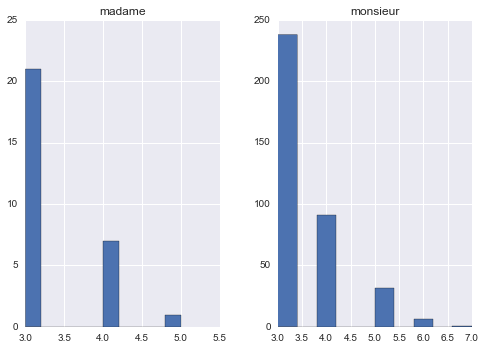

In [552]:
monsieur_duration_list = df_monsieur['Duration of Bachelor'].tolist()
madame_duration_list = df_madame['Duration of Bachelor'].tolist()

tmp = pd.concat([pd.DataFrame({'monsieur': monsieur_duration_list})
           ,pd.DataFrame({'madame': madame_duration_list})], ignore_index=True, axis=1)
tmp.columns = ['monsieur', 'madame']
tmp.hist()

The Wilcoxon rank-sum test tests the null hypothesis that two sets of measurements are drawn from the same distribution. We are testing if male and female durations of bachelor are comming from the same distribution (null hypothesis).

In [529]:
res = scipy.stats.ranksums( df_madame['Duration of Bachelor'].tolist(), df_monsieur['Duration of Bachelor'].tolist())
res.pvalue

0.39364493314799009

As explained in https://en.wikipedia.org/wiki/P-value - pvalue > 0.1 means that we accept the null hypothesis and so we conclude that there is no significant difference.

## Exercise 2

<h2>Strategy:</h2>

Our strategy to handle the master project data is the following.

***Master projects:*** The first hard choice was how to handle the student without any master projects. It appears that little of them have a master project registerd. However, as it is the mandatory thing to do to finish an epfl master, it looked for us that it was a mandatory data to have. Therefore, we decided to drop the students with no master projects, as we could not know if they really finished epfl. Also, it was asked in the instructions to check if they had one, so it seemed to us important to take this factor into account correctly.

***At least one class: *** We decided to take only the students that were registered at least once in MA1,MA2 or MA3. As it could be exchange students coming just for the master project.

***Basic duration: *** Therefore, we will use the students that have at least one semester and one master project registered. We will compute the duration between the earliest semester that they made at epfl, and the latest master project that they realized (as they could have done 2 masters projects if they failed the first one). This will be our "basic duration".

*** Infered duration:*** As there were some missing datas, we decided to try to infer the missing semesters if there were some, as was asked in the instructions. If we had only MA3 data, we decided to drop the student because we could not fiably reconstruct the data (it would not be possible to make the difference between 1 year or 1.5 years duration).<br>
The basic idea was to test if the "basic duration" was too short to be possible. As we know that we need at least 2 years to finish the master for students without specialization/minor, if it was too short we would make it longer to reach the minimum possible duration.

***Statistical tests:*** With these datas, we could perform t-test to check if there was any difference between specialization.

<h3>Importing data</h3><br>
We get the master data from the files.

In [530]:
masters_sem1 = glob.glob('.\\data\\[0-9]*-[0-9]*Master semestre 1')
masters_sem2 = glob.glob('.\\data\\[0-9]*-[0-9]*Master semestre 2')
masters_sem3 = glob.glob('.\\data\\[0-9]*-[0-9]*Master semestre 3')
projectsA = glob.glob('.\\data\\[0-9]*-[0-9]*Projet Master automne')
projectsP = glob.glob('.\\data\\[0-9]*-[0-9]*Projet Master printemps')

masters_sem1_df_list = [pd.read_pickle(data_file) for data_file in masters_sem1]
masters_sem2_df_list = [pd.read_pickle(data_file) for data_file in masters_sem2]
masters_sem3_df_list = [pd.read_pickle(data_file) for data_file in masters_sem3]
projectsA_df_list = [pd.read_pickle(data_file) for data_file in projectsA]
projectsP_df_list = [pd.read_pickle(data_file) for data_file in projectsP]

In [531]:
projectsP_df_list[0]

,Civilité,Nom Prénom,Spécialisation,Statut,No Sciper,Period Academic,Period pedagogic
2,Monsieur,Brutsche Florian,Internet computing,Congé,159852,2007-2008,Projet Master printemps
3,Monsieur,Dotta Mirco,NaN,Stage,153819,2007-2008,Projet Master printemps
4,Monsieur,Hügli Michael,NaN,Stage,145957,2007-2008,Projet Master printemps
5,Monsieur,Indra Saurabh,NaN,Présent,173257,2007-2008,Projet Master printemps
6,Monsieur,Lépine Simon,Biocomputing,Présent,160150,2007-2008,Projet Master printemps
7,Monsieur,Stewart Conail,NaN,Présent,173527,2007-2008,Projet Master printemps


<h3>Correcting the year</h3>
As for the bachelor students, we will again correct the year according to if a student is in the spring or autumn semester

In [532]:
def correcting_year_Automn(automnDf):
    # We select the second year of the column Period Academic and add 0.5 as it should be the second half of the year
    for df in automnDf:
        df["Period Academic"]=int(df['Period Academic'][2].split('-')[0].replace(" ", "")) + 0.5

In [533]:
correcting_year_Automn(masters_sem1_df_list)
correcting_year_Automn(projectsA_df_list)

In [534]:
masters_sem1_df_list[0].head(3)

,Civilité,Nom Prénom,Spécialisation,Statut,Type Echange,Ecole Echange,No Sciper,Period Academic,Period pedagogic
2,Monsieur,Aeberhard François-Xavier,NaN,Présent,NaN,NaN,153066,2007.5,Master semestre 1
3,Madame,Agarwal Megha,NaN,Présent,NaN,NaN,180027,2007.5,Master semestre 1
4,Monsieur,Anagnostaras David,NaN,Présent,NaN,NaN,152232,2007.5,Master semestre 1


In [535]:
def correcting_year_Spring(springDf):
    # We select the second year of the column Period Academic
    for df in springDf:
        df["Period Academic"] = int(df['Period Academic'][2].split('-')[1])  

In [536]:
correcting_year_Spring(masters_sem2_df_list)
correcting_year_Spring(projectsP_df_list)

In [537]:
masters_sem2_df_list[0].head(3)

,Civilité,Nom Prénom,Spécialisation,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Period Academic,Period pedagogic
2,Monsieur,Aeberhard François-Xavier,NaN,NaN,Présent,NaN,NaN,153066,2008,Master semestre 2
3,Madame,Agarwal Megha,NaN,NaN,Présent,NaN,NaN,180027,2008,Master semestre 2
4,Monsieur,Anagnostaras David,NaN,"Mineur en Management, technologie et entrepren...",Présent,NaN,NaN,152232,2008,Master semestre 2


<h3>Merging masters classes dataframes</h3><br>
We add the "master 2" dataframe after the "master 1" dataframe (using the append function)

In [538]:
master1_df = pd.concat(masters_sem1_df_list, ignore_index=True)
master2_df = pd.concat(masters_sem2_df_list, ignore_index=True)
master_courses = master1_df.append(master2_df)
master_courses.head(2)

,Civilité,Ecole Echange,Mineur,No Sciper,Nom Prénom,Period Academic,Period pedagogic,Spécialisation,Statut,Type Echange
0,Monsieur,NaN,NaN,153066,Aeberhard François-Xavier,2007.5,Master semestre 1,NaN,Présent,NaN
1,Madame,NaN,NaN,180027,Agarwal Megha,2007.5,Master semestre 1,NaN,Présent,NaN


<h3>Getting the earliest and latest stay of a student</h3><br>
To know when a student has its earliest semester registered, we will sort the dataframe containing all the master semesters by date and drop all the duplicates while keeping the first data for each student. This will result in a dataframe with only the earliest semester of each student. We will do the same for the master project datas (except we will keep the last student as we want the latest stay).

We sort "merged masters" dataframe by date and then by "master 2" and "master 1" (We have put "master 2" before "master 1" if "master 1" and "master 2" have the same date, since it will mean that the student started its master in spring, so marked as "master 2").

First we prepare the sort by adding this "sorting semester" column that will help. This is a quicky "trick" as we can only sort by one specific order (ascending here) but we use two sorting values.

In [539]:
def prepare_sort(row):
    if row['Period pedagogic'] == 'Master semestre 1':
        return -1
    else:
        return -2

master_courses2 = master_courses.copy()
master_courses2['sorting semester'] = master_courses2.apply(prepare_sort, axis=1)
master_courses2.head(2)

,Civilité,Ecole Echange,Mineur,No Sciper,Nom Prénom,Period Academic,Period pedagogic,Spécialisation,Statut,Type Echange,sorting semester
0,Monsieur,NaN,NaN,153066,Aeberhard François-Xavier,2007.5,Master semestre 1,NaN,Présent,NaN,-1
1,Madame,NaN,NaN,180027,Agarwal Megha,2007.5,Master semestre 1,NaN,Présent,NaN,-1


Then, we sort using the two values and drop the duplicates.

In [540]:
master_courses_sorted = master_courses2.sort_values(['Period Academic', 'sorting semester'], ascending=True)
master_courses_sorted = master_courses_sorted.drop_duplicates(subset='No Sciper', keep='first')
master_courses_sorted.head(2)

,Civilité,Ecole Echange,Mineur,No Sciper,Nom Prénom,Period Academic,Period pedagogic,Spécialisation,Statut,Type Echange,sorting semester
0,Monsieur,NaN,NaN,153066,Aeberhard François-Xavier,2007.5,Master semestre 1,NaN,Présent,NaN,-1
1,Madame,NaN,NaN,180027,Agarwal Megha,2007.5,Master semestre 1,NaN,Présent,NaN,-1


Here, we merge the master projects dataframes and get the latest project registered for each student (one student may have done two master projects).

In [541]:
mp_a = pd.concat(projectsA_df_list, ignore_index=True)
mp_p = pd.concat(projectsP_df_list, ignore_index=True)

In [542]:
master_proj_df = pd.concat([mp_a, mp_p], ignore_index=True)

master_proj_df = master_proj_df.sort_values(['Period Academic'], ascending=True)
master_proj_df = master_proj_df.drop_duplicates(subset='No Sciper', keep='last')
master_proj_df.head()

,Civilité,Ecole Echange,Mineur,No Sciper,Nom Prénom,Period Academic,Period pedagogic,Spécialisation,Statut,Type Echange
88,Monsieur,NaN,NaN,145957,Hügli Michael,2008.0,Projet Master printemps,NaN,Stage,NaN
89,Monsieur,NaN,NaN,173257,Indra Saurabh,2008.0,Projet Master printemps,NaN,Présent,NaN
90,Monsieur,NaN,NaN,160150,Lépine Simon,2008.0,Projet Master printemps,Biocomputing,Présent,NaN
91,Monsieur,NaN,NaN,173527,Stewart Conail,2008.0,Projet Master printemps,NaN,Présent,NaN
87,Monsieur,NaN,NaN,153819,Dotta Mirco,2008.0,Projet Master printemps,NaN,Stage,NaN


<h3>Merging master classes and master projects students table</h3>

In [543]:
students = pd.merge(master_courses_sorted, master_proj_df, on='No Sciper', how='inner')
students.head()

,Civilité_x,Ecole Echange_x,Mineur_x,No Sciper,Nom Prénom_x,Period Academic_x,Period pedagogic_x,Spécialisation_x,Statut_x,Type Echange_x,sorting semester,Civilité_y,Ecole Echange_y,Mineur_y,Nom Prénom_y,Period Academic_y,Period pedagogic_y,Spécialisation_y,Statut_y,Type Echange_y
0,Madame,NaN,NaN,180027,Agarwal Megha,2007.5,Master semestre 1,NaN,Présent,NaN,-1,Madame,NaN,NaN,Agarwal Megha,2008.5,Projet Master automne,NaN,Stage,NaN
1,Madame,NaN,NaN,154573,Benabdallah Zeineb,2007.5,Master semestre 1,NaN,Présent,NaN,-1,Madame,NaN,NaN,Benabdallah Zeineb,2010.0,Projet Master printemps,Biocomputing,Présent,NaN
2,Monsieur,NaN,NaN,172687,Billaud Joël,2007.5,Master semestre 1,NaN,Présent,NaN,-1,Monsieur,NaN,NaN,Billaud Joël,2009.0,Projet Master printemps,NaN,Stage,NaN
3,Monsieur,NaN,NaN,180072,Campora Simone,2007.5,Master semestre 1,Internet computing,Présent,NaN,-1,Monsieur,NaN,NaN,Campora Simone,2009.0,Projet Master printemps,Internet computing,Stage,NaN
4,Monsieur,NaN,NaN,160225,Cassata Alexandre,2007.5,Master semestre 1,NaN,Présent,NaN,-1,Monsieur,NaN,NaN,Cassata Alexandre,2009.0,Projet Master printemps,NaN,Stage,NaN


<h3>Duration computation</h3>
We keep the interesting columns and compute the duration.

In [544]:
students = pd.DataFrame({'No Sciper': students['No Sciper'], 'Civilité' :students['Civilité_x'], 'Spécialisation': students['Spécialisation_y'], 'Mineur': students['Mineur_y'], 'Duration of Master': students['Period Academic_y'] - students['Period Academic_x']})

In [545]:
students.head()

,Civilité,Duration of Master,Mineur,No Sciper,Spécialisation
0,Madame,1.0,NaN,180027,NaN
1,Madame,2.5,NaN,154573,Biocomputing
2,Monsieur,1.5,NaN,172687,NaN
3,Monsieur,1.5,NaN,180072,Internet computing
4,Monsieur,1.5,NaN,160225,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028FDFC01BA8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000028FE10AD128>]], dtype=object)

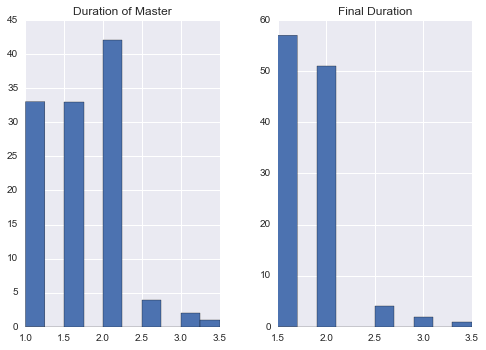

In [553]:
students.hist()

Here we compute the new duration. We looked at all the different cases and changed the duration acordingly.

In [546]:
MASTER_MIN_DURATION_NO_SPE = 1.5
MASTER_MIN_DURATION_SPE = 2.

def make_final_duration(row):
    duration = float(row['Duration of Master'])
    minor = row['Mineur']
    spec = row['Spécialisation']
    
    no_m_sp = pd.isnull(minor) and pd.isnull(spec)
    
    if duration < MASTER_MIN_DURATION_NO_SPE and no_m_sp:
        return MASTER_MIN_DURATION_NO_SPE
    if duration < MASTER_MIN_DURATION_SPE and not no_m_sp:
        if duration == 1.5:
            return MASTER_MIN_DURATION_SPE
        else:
            return 2.5
    else:
        return duration

In [547]:
students['Final Duration'] = students.apply(make_final_duration, axis=1)

In [548]:
students.describe()

,Duration of Master,Final Duration
count,115.000000,115.000000
mean,1.617391,1.800000
std,0.510119,0.361527
min,1.000000,1.500000
25%,1.000000,1.500000
50%,1.500000,2.000000
75%,2.000000,2.000000
max,3.500000,3.500000


<h3>Statistical tests</h3>

In [549]:
stup = students.copy()

In [550]:
gb_obj = stup.groupby('Spécialisation')

In [554]:
mean_by_specialization_df = pd.DataFrame({name : [group['Duration of Master'].mean()] for name, group in gb_obj})
mean_by_specialization_df

,Biocomputing,Computer Engineering - SP,Foundations of Software,Information Security - SP,Internet computing,Service science,"Signals, Images and Interfaces",Software Systems
0,2.5,2.0,2.071429,2.0,1.85,2.0,1.5,2.0


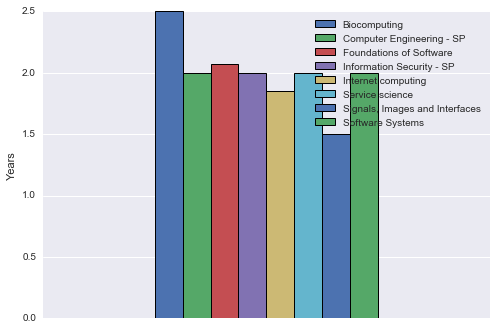

In [564]:
ax = mean_by_specialization_df.plot(kind='bar', lw=1)
ax.set_xlabel("Specializations")
ax.set_ylabel("Years")
ax.axes.get_xaxis().set_visible(False)

The ttest_1sample is a two-sided test for the null hypothesis that the expected value (mean) of a sample of independent observations a is equal to the given population mean. In this situation, the population is all the master students and the sample is the student that choose a specific specialisation. 

In [551]:
p_values = {}

for name, group in gb_obj:
    print(name,
    group['Final Duration'].tolist())
 
    print(scipy.stats.ttest_1samp(group['Final Duration'].tolist()
                                              , students['Final Duration'].mean()))
    print("\n")

Biocomputing [2.5]
Ttest_1sampResult(statistic=nan, pvalue=nan)


Computer Engineering - SP [2.0, 2.0]
Ttest_1sampResult(statistic=inf, pvalue=0.0)


Foundations of Software [2.0, 2.0, 2.0, 3.0, 3.0, 2.0, 2.0]
Ttest_1sampResult(statistic=2.633628675421043, pvalue=0.038870365703458587)


Information Security - SP [2.0, 2.0]
Ttest_1sampResult(statistic=inf, pvalue=0.0)


Internet computing [2.0, 2.0, 2.0, 2.0, 2.5, 2.0, 2.0, 2.0, 2.0, 2.0]
Ttest_1sampResult(statistic=4.9999999999999956, pvalue=0.00073896790980324716)


Service science [2.0]
Ttest_1sampResult(statistic=nan, pvalue=nan)


Signals, Images and Interfaces [2.0]
Ttest_1sampResult(statistic=nan, pvalue=nan)


Software Systems [2.0, 2.0]
Ttest_1sampResult(statistic=inf, pvalue=0.0)




C:\Users\Sergii\Anaconda3\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


We observe Nan value for specialisation containing only one entry. We did not take them into account as making statistic on sample of one student is meaningless. 

As explain in https://en.wikipedia.org/wiki/P-value, the only difference that can be observable with a threshold of 1% is the specialisation of Foundations of Software. Those students took more time to finish their Master.